In [1]:
import tensorflow as tf
tf.random.set_seed(1)
tf.compat.v1.enable_eager_execution()

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [2]:
import numpy as np
np.random.seed(1)

import gensim
import pandas as pd
import matplotlib.pyplot as plt
import pprint

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense, \
    SpatialDropout1D, Bidirectional, Conv1D, concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import Callback

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix

from time import time

%matplotlib inline

In [3]:
df = pd.read_csv('../data/data.csv')
df.head()

,word,tag
0,Pengamat,O
1,politik,O
2,dari,O
3,Universitas,B-ORGANIZATION
4,Gadjah,I-ORGANIZATION


In [4]:
sentences = []
cnt = 1

for i in df.itertuples():
    sentences.append(cnt)
    
    if '.' in str(i.word):
        cnt += 1
        
df['sentence #'] = sentences
df.head()

,word,tag,sentence #
0,Pengamat,O,1
1,politik,O,1
2,dari,O,1
3,Universitas,B-ORGANIZATION,1
4,Gadjah,I-ORGANIZATION,1


In [5]:
agg_func = lambda s: [(w, t) for w, t in zip(s['word'].values.tolist(), s['tag'].values.tolist())]
grouped = df.groupby('sentence #').apply(agg_func)
sentences = [s for s in grouped]

In [6]:
words = list(set(df['word'].values))
words.append('PADDING')
num_words = len(words)
tags = list(set(df['tag'].values))
num_tags = len(tags)
print(f'num words: {num_words}, num tags: {num_tags}')

num words: 13031, num tags: 21


In [7]:
tags = sorted([t for t in tags if t != 'O'], key=lambda x: (x[2], x[0]))
tags.append('O')
pprint.pprint(tags)

['B-LOCATION',
 'I-LOCATION',
 'L-LOCATION',
 'U-LOCATION',
 'B-ORGANIZATION',
 'I-ORGANIZATION',
 'L-ORGANIZATION',
 'U-ORGANIZATION',
 'B-PERSON',
 'I-PERSON',
 'L-PERSON',
 'U-PERSON',
 'B-QUANTITY',
 'I-QUANTITY',
 'L-QUANTITY',
 'U-QUANTITY',
 'B-TIME',
 'I-TIME',
 'L-TIME',
 'U-TIME',
 'O']


In [8]:
word2idx = {w: i for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}
pprint.pprint(tag2idx)

{'B-LOCATION': 0,
 'B-ORGANIZATION': 4,
 'B-PERSON': 8,
 'B-QUANTITY': 12,
 'B-TIME': 16,
 'I-LOCATION': 1,
 'I-ORGANIZATION': 5,
 'I-PERSON': 9,
 'I-QUANTITY': 13,
 'I-TIME': 17,
 'L-LOCATION': 2,
 'L-ORGANIZATION': 6,
 'L-PERSON': 10,
 'L-QUANTITY': 14,
 'L-TIME': 18,
 'O': 20,
 'U-LOCATION': 3,
 'U-ORGANIZATION': 7,
 'U-PERSON': 11,
 'U-QUANTITY': 15,
 'U-TIME': 19}


In [9]:
max_len = 40
X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, padding='post', value=num_words-1)

y = [[tag2idx[w[1]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, padding='post', value=tag2idx['O'])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [10]:
x_train, x_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.3, random_state=1)
x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=0.5, random_state=1)

In [11]:
def create_embedding_matrix(embedding_type, dims):
    # path
    EMBED_PATH = "../checkpoint/embedding/{0}/d{1}/{0}_wiki_id_case_{1}".format(embedding_type, dims)
    print(f'Load pretrained embedding from {EMBED_PATH}')
    # load pretrained embedding
    if embedding_type == 'w2v':
        model = gensim.models.Word2Vec.load(EMBED_PATH)
    elif embedding_type == 'glove':
        model = gensim.models.KeyedVectors.load_word2vec_format(EMBED_PATH)
    elif embedding_type == 'fasttext':
        model = gensim.models.FastText.load(EMBED_PATH)
    # initiate embedding matrix
    embedding_matrix = np.zeros((len(words), dims))
    # create embedding matrix
    for i, w in enumerate(words):
        try:
            embedding_matrix[i] = model.wv[w]
        except (TypeError, KeyError): # if the current word does not appear in our corpus
            embedding_matrix[i] = np.random.normal(0, np.sqrt(0.25), dims)
    
    return embedding_matrix

In [12]:
def f1_score_micro(y_true, y_pred):
    y_true = np.argmax(y_true.numpy(), axis=-1).reshape(-1)
    y_pred = np.argmax(y_pred.numpy(), axis=-1).reshape(-1)
    
    # label O will be ignored during training and evaluation
    o_pad_idx = np.where(y_true==20) # 20 is the idx for label O
    
    # remove label O
    y_true = np.delete(y_true, o_pad_idx)
    y_pred = np.delete(y_pred, o_pad_idx)
    
    # compute f1 score with micro average
    score = f1_score(y_true, y_pred, average='micro')
    
    return score

In [13]:
def create_model(params, output_dim, embedding_type=None):
    # input layer
    input_sequence = Input(shape=(max_len, ))
    # embedding layer
    if embedding_type is not None:
        embedding_matrix = create_embedding_matrix(embedding_type, output_dim)
        model = Embedding(
            input_dim= embedding_matrix.shape[0], 
            weights=[embedding_matrix], 
            output_dim=embedding_matrix.shape[1], 
            input_length=max_len,
            trainable=False
        )(input_sequence)
    else:
        model = Embedding(
            input_dim=num_words,
            output_dim=output_dim,
            input_length=max_len,
        )(input_sequence)
    # dropout layer
    model = SpatialDropout1D(params['dropout'])(model)
    # lstm layer
    model = Bidirectional(LSTM(units=params['lstm_units'], return_sequences=True))(model)
    # output layer
    output_sequence = Dense(num_tags, activation='softmax')(model)
    # model
    model = Model(input_sequence, output_sequence)
    # learning algorithm (optimizer)
    if params['optimizer'] == 'Nadam':
        optm = tf.keras.optimizers.Nadam(lr=params['lr'])
    if params['optimizer'] == 'Adam':
        optm = tf.keras.optimizers.Adam(lr=params['lr'])
    if params['optimizer'] == 'RMSprop':
        optm = tf.keras.optimizers.RMSprop(lr=params['lr'])
    # loss
    loss = tf.keras.losses.CategoricalCrossentropy()
    # model compile
    model.compile(loss=loss, optimizer=optm, metrics=[f1_score_micro], run_eagerly=True)
    
    return model

In [14]:
def plot_history(history):
    # plot loss
    fig = plt.figure(figsize=(7,5))
    plt.plot(history.history['loss'], "-o")
    plt.plot(history.history['val_loss'], "-o")
    plt.title('loss')
    plt.xlabel('epoch')
    plt.ylim(0,1)
    plt.show();
    
    # plot f1 score
    fig = plt.figure(figsize=(7,5))
    plt.plot(history.history['f1_score_micro'], "-o")
    plt.plot(history.history['val_f1_score_micro'], "-o")
    plt.title('f1_micro')
    plt.xlabel('epoch')
    plt.ylim(0,1)
    plt.show();

In [15]:
def plot_confusion_matrix(y_true, y_pred):
    # plot confusion matrix
    fig, ax = plt.subplots(figsize=(10,10))
    cm_matrix = confusion_matrix(y_true, y_pred)
    cm_matrix = np.delete(cm_matrix, (20), axis=0)
    cm_matrix = np.delete(cm_matrix, (20), axis=1)
    ax.matshow(cm_matrix, cmap=plt.cm.Blues)
    for i in range(num_tags-1):
        for j in range(num_tags-1):
            c = cm_matrix[j,i]
            ax.text(i, j, str(c), va='center', ha='center')
    plt.xticks(range(num_tags-1),['{} ({})'.format(tags[:-1][i],i) for i in range(num_tags-1)])
    plt.yticks(range(num_tags-1),['{} ({})'.format(tags[:-1][i],i) for i in range(num_tags-1)])
    plt.xticks(rotation=90)
    plt.show();

In [16]:
def train_model(params, output_dim, embedding_type):
    print('### Model Configuration ###')
    print(f'output_dim: {output_dim}, embedding_type: {embedding_type}, params: {params}')
    
    early_stopping = tf.keras.callbacks \
        .EarlyStopping(patience=10, monitor='val_f1_score_micro', mode='max')
    
    # create model
    model = create_model(params, output_dim, embedding_type)
    print('\nModel Summary')
    model.summary()
    
    # train model
    start = time()
    history = model.fit(
        x_train, np.array(y_train),
        validation_data=(x_val, np.array(y_val)),
        epochs=params['epochs'], verbose=1, callbacks=[early_stopping], batch_size=params['batch_size']
    )
    train_time = time()-start
    print(f'\nTraining time: {train_time}s')
    
    # evaluate model with testing set
    y_true = np.argmax(np.array(y_test), axis=-1).reshape(-1)
    y_pred = np.argmax(model.predict(x_test), axis=-1).reshape(-1)
    
    # print classification report
    print('\nClassification Report')
    print(classification_report(y_true, y_pred, target_names=tags, zero_division=0))
    
    ignored_idx = np.where(y_true==20) # ignore label O (idx=20)
    y_true = np.delete(y_true, ignored_idx)
    y_pred = np.delete(y_pred, ignored_idx)
    
    plot_history(history)
    score = f1_score(y_true, y_pred, average='micro')
    print(f"micro averaged f1 score: {score}")
    plot_confusion_matrix(y_true, y_pred)
    
    print()
    print()
    
    return score

In [17]:
params = {
    'optimizer': 'Adam',
    'lr': 0.001,
    'lstm_units': 100,
    'dropout': 0.5,
    'batch_size': 64,
    'epochs': 200
}

In [18]:
embedding_types = [None, 'w2v', 'glove', 'fasttext']
output_dims = [50, 100, 200, 300]

### Model Configuration ###
output_dim: 50, embedding_type: None, params: {'optimizer': 'Adam', 'lr': 0.001, 'lstm_units': 100, 'dropout': 0.5, 'batch_size': 64, 'epochs': 200}

Model Summary
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 40, 50)            651550    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 40, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 40, 200)           120800    
_________________________________________________________________
dense (Dense)                (None, 40, 21)            4221      
Total params: 776,571
Trainable params: 776,571
Non-trainable param

Epoch 46/200
54/54 [==============================] - 2s 32ms/step - loss: 0.0185 - f1_score_micro: 0.9541 - val_loss: 0.2641 - val_f1_score_micro: 0.5906
Epoch 47/200
54/54 [==============================] - 2s 32ms/step - loss: 0.0169 - f1_score_micro: 0.9581 - val_loss: 0.2661 - val_f1_score_micro: 0.6018
Epoch 48/200
54/54 [==============================] - 2s 32ms/step - loss: 0.0173 - f1_score_micro: 0.9578 - val_loss: 0.2638 - val_f1_score_micro: 0.6163
Epoch 49/200
54/54 [==============================] - 2s 32ms/step - loss: 0.0175 - f1_score_micro: 0.9561 - val_loss: 0.2682 - val_f1_score_micro: 0.5976
Epoch 50/200
54/54 [==============================] - 2s 32ms/step - loss: 0.0172 - f1_score_micro: 0.9566 - val_loss: 0.2713 - val_f1_score_micro: 0.6010
Epoch 51/200
54/54 [==============================] - 2s 32ms/step - loss: 0.0156 - f1_score_micro: 0.9630 - val_loss: 0.2697 - val_f1_score_micro: 0.6004
Epoch 52/200
54/54 [==============================] - 2s 32ms/step - l

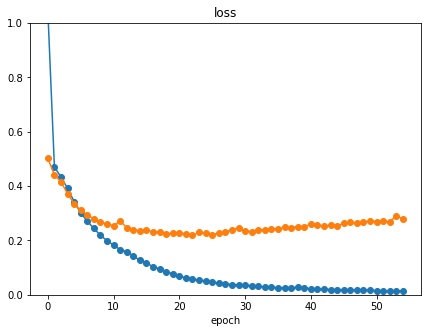

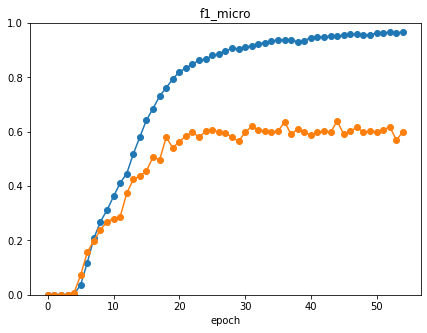

micro averaged f1 score: 0.5993280134397312


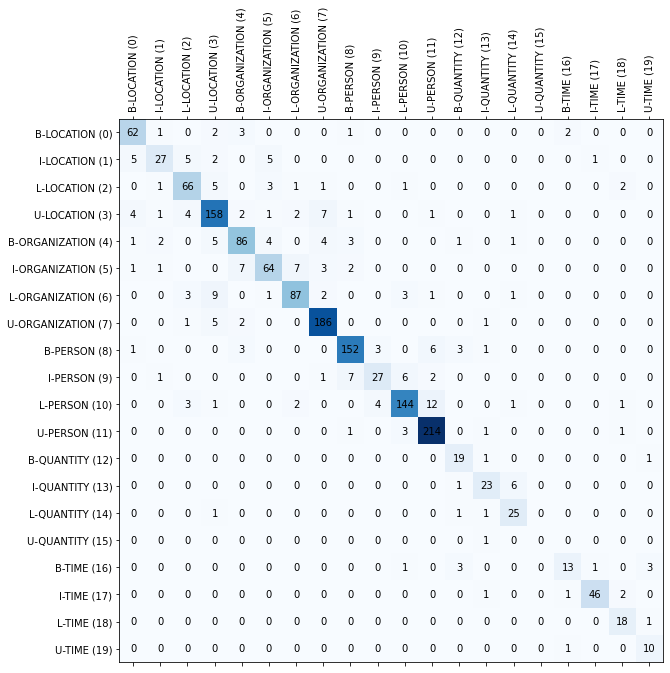



### Model Configuration ###
output_dim: 100, embedding_type: None, params: {'optimizer': 'Adam', 'lr': 0.001, 'lstm_units': 100, 'dropout': 0.5, 'batch_size': 64, 'epochs': 200}

Model Summary
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 40, 100)           1303100   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 40, 100)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 200)           160800    
_________________________________________________________________
dense_1 (Dense)              (None, 40, 21)            4221      
Total params: 1,468,121
Trainable params: 1,468,121
Non-traina

Epoch 46/200
54/54 [==============================] - 2s 39ms/step - loss: 0.0102 - f1_score_micro: 0.9776 - val_loss: 0.2666 - val_f1_score_micro: 0.6297
Epoch 47/200
54/54 [==============================] - 2s 39ms/step - loss: 0.0091 - f1_score_micro: 0.9804 - val_loss: 0.2822 - val_f1_score_micro: 0.6110
Epoch 48/200
54/54 [==============================] - 2s 39ms/step - loss: 0.0088 - f1_score_micro: 0.9798 - val_loss: 0.2859 - val_f1_score_micro: 0.6190
Epoch 49/200
54/54 [==============================] - 2s 39ms/step - loss: 0.0083 - f1_score_micro: 0.9826 - val_loss: 0.2875 - val_f1_score_micro: 0.6155
Epoch 50/200
54/54 [==============================] - 2s 39ms/step - loss: 0.0075 - f1_score_micro: 0.9835 - val_loss: 0.2915 - val_f1_score_micro: 0.6184
Epoch 51/200
54/54 [==============================] - 2s 39ms/step - loss: 0.0079 - f1_score_micro: 0.9830 - val_loss: 0.2899 - val_f1_score_micro: 0.6102
Epoch 52/200
54/54 [==============================] - 2s 39ms/step - l

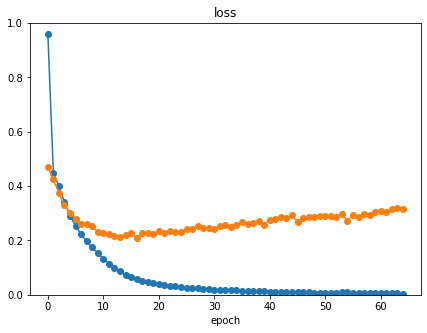

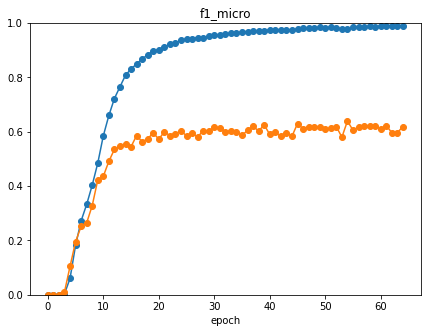

micro averaged f1 score: 0.619907601847963


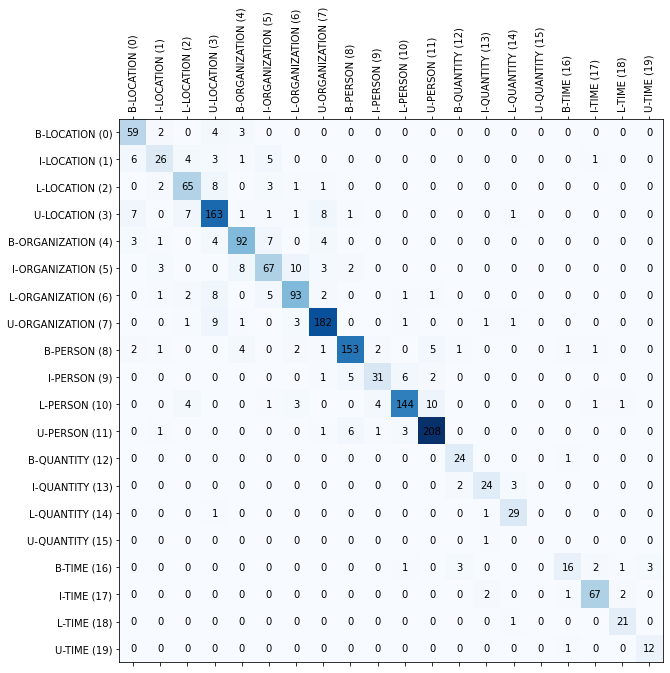



### Model Configuration ###
output_dim: 200, embedding_type: None, params: {'optimizer': 'Adam', 'lr': 0.001, 'lstm_units': 100, 'dropout': 0.5, 'batch_size': 64, 'epochs': 200}

Model Summary
Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 40, 200)           2606200   
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 40, 200)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 40, 200)           240800    
_________________________________________________________________
dense_2 (Dense)              (None, 40, 21)            4221      
Total params: 2,851,221
Trainable params: 2,851,221
Non-traina

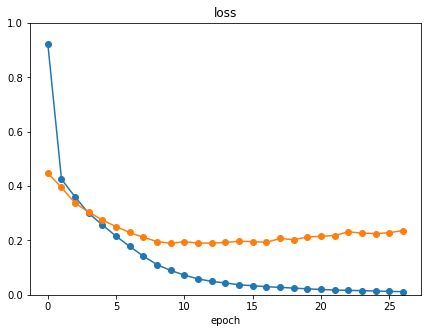

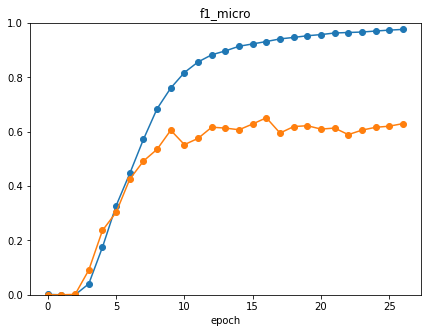

micro averaged f1 score: 0.6518269634607308


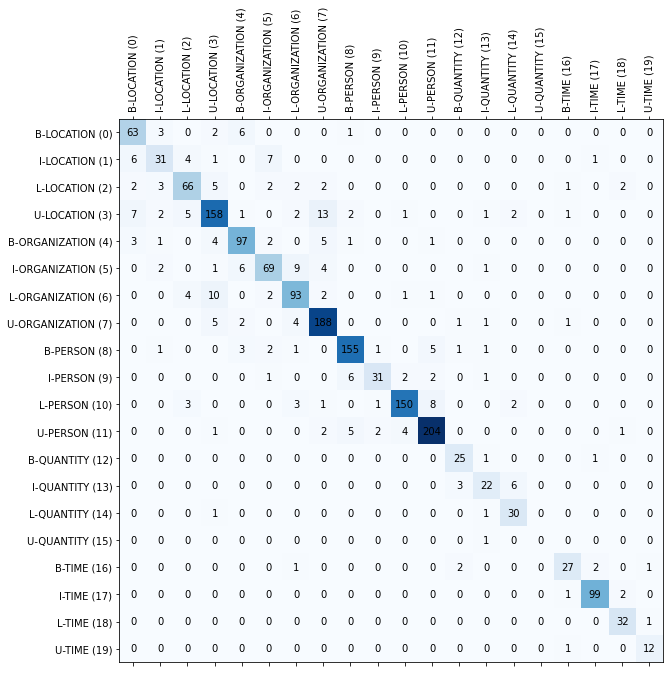



### Model Configuration ###
output_dim: 300, embedding_type: None, params: {'optimizer': 'Adam', 'lr': 0.001, 'lstm_units': 100, 'dropout': 0.5, 'batch_size': 64, 'epochs': 200}

Model Summary
Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 40, 300)           3909300   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 40, 300)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 40, 200)           320800    
_________________________________________________________________
dense_3 (Dense)              (None, 40, 21)            4221      
Total params: 4,234,321
Trainable params: 4,234,321
Non-traina

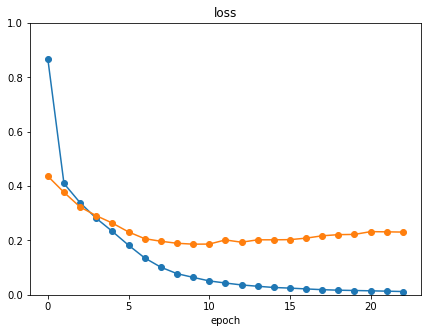

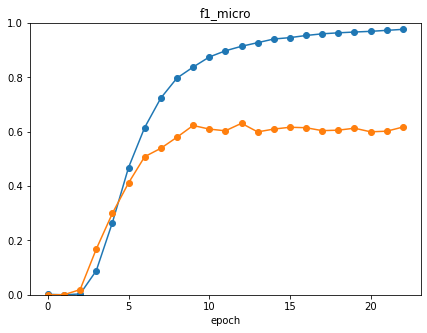

micro averaged f1 score: 0.636707265854683


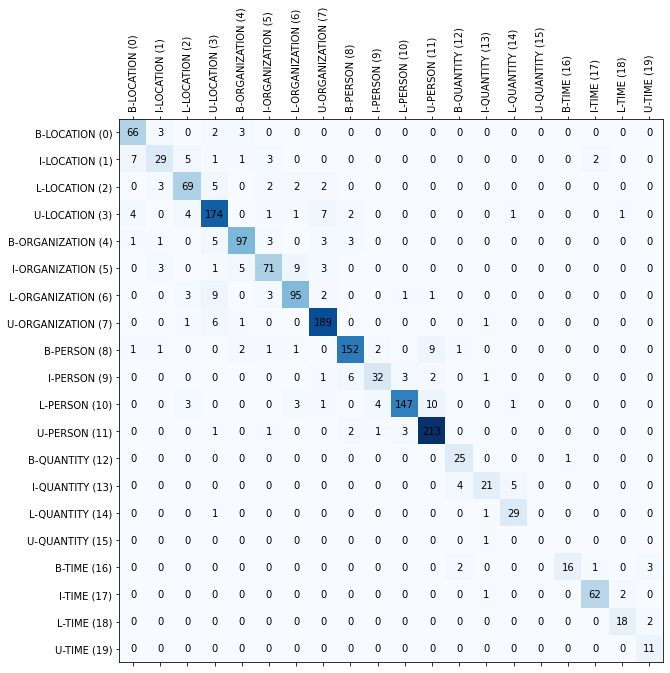



### Model Configuration ###
output_dim: 50, embedding_type: w2v, params: {'optimizer': 'Adam', 'lr': 0.001, 'lstm_units': 100, 'dropout': 0.5, 'batch_size': 64, 'epochs': 200}
Load pretrained embedding from ../checkpoint/embedding/w2v/d50/w2v_wiki_id_case_50

Model Summary
Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 40, 50)            651550    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 40, 50)            0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 40, 200)           120800    
_________________________________________________________________
dense_4 (Dense)              (None, 40, 21)    

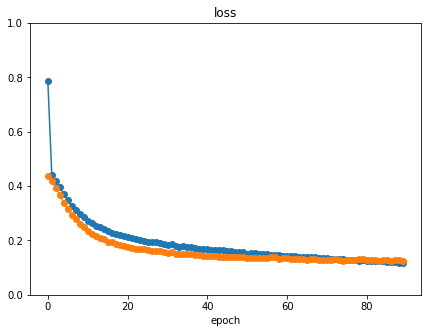

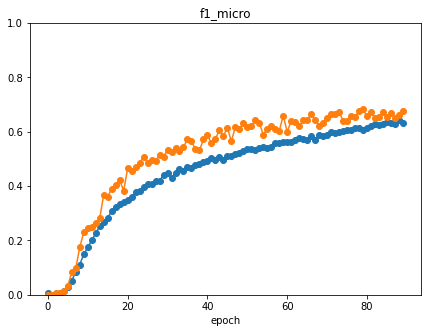

micro averaged f1 score: 0.6572868542629148


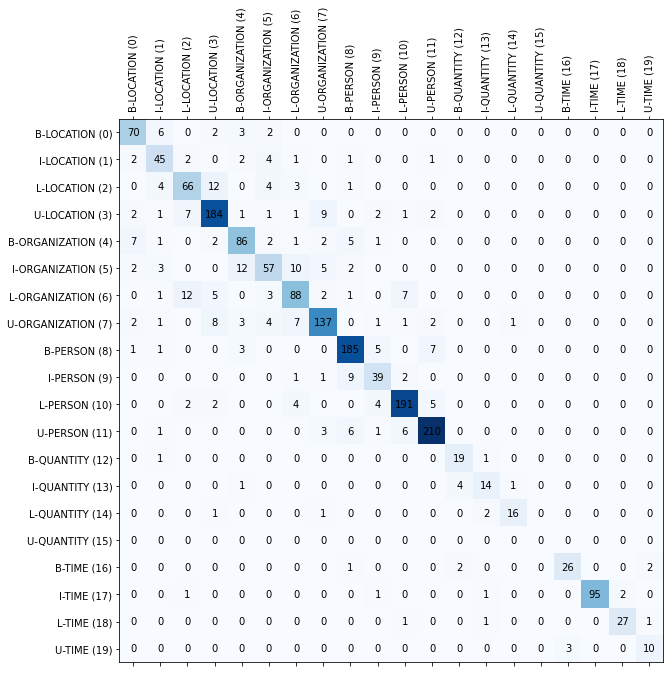



### Model Configuration ###
output_dim: 100, embedding_type: w2v, params: {'optimizer': 'Adam', 'lr': 0.001, 'lstm_units': 100, 'dropout': 0.5, 'batch_size': 64, 'epochs': 200}
Load pretrained embedding from ../checkpoint/embedding/w2v/d100/w2v_wiki_id_case_100

Model Summary
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 40, 100)           1303100   
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 40, 100)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 40, 200)           160800    
_________________________________________________________________
dense_5 (Dense)              (None, 40, 21) 

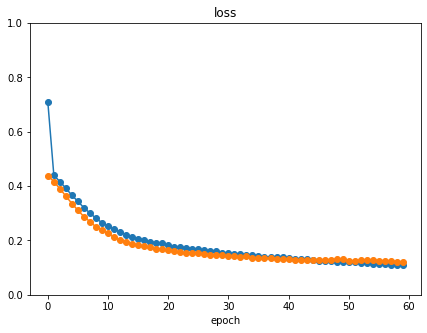

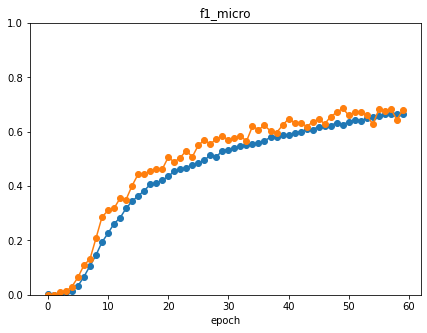

micro averaged f1 score: 0.6522469550608988


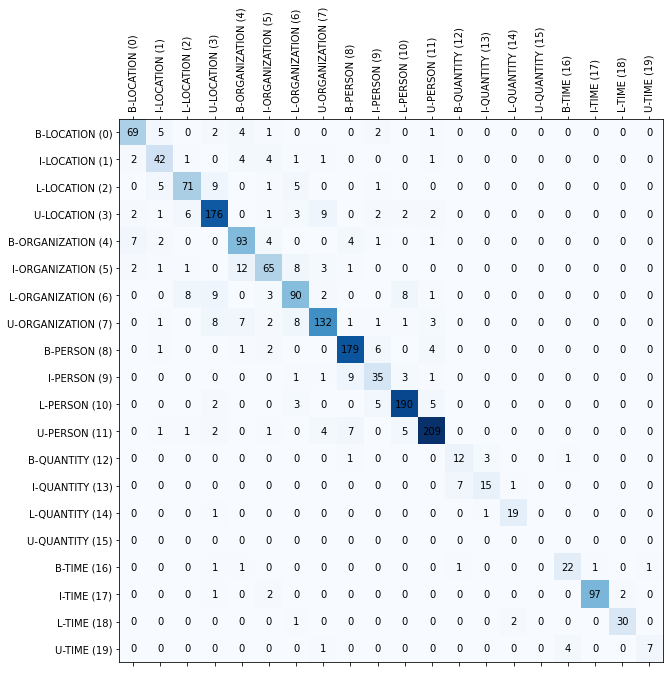



### Model Configuration ###
output_dim: 200, embedding_type: w2v, params: {'optimizer': 'Adam', 'lr': 0.001, 'lstm_units': 100, 'dropout': 0.5, 'batch_size': 64, 'epochs': 200}
Load pretrained embedding from ../checkpoint/embedding/w2v/d200/w2v_wiki_id_case_200

Model Summary
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 40, 200)           2606200   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 40, 200)           0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 40, 200)           240800    
_________________________________________________________________
dense_6 (Dense)              (None, 40, 21) 

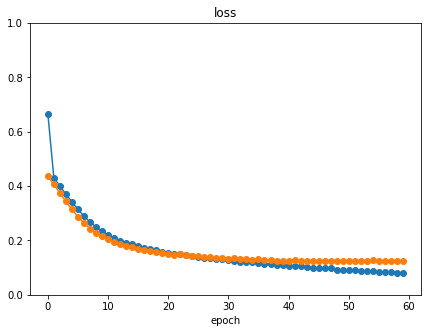

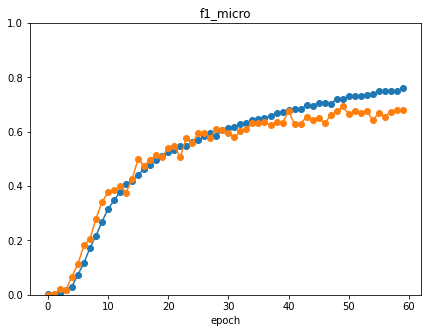

micro averaged f1 score: 0.6652666946661067


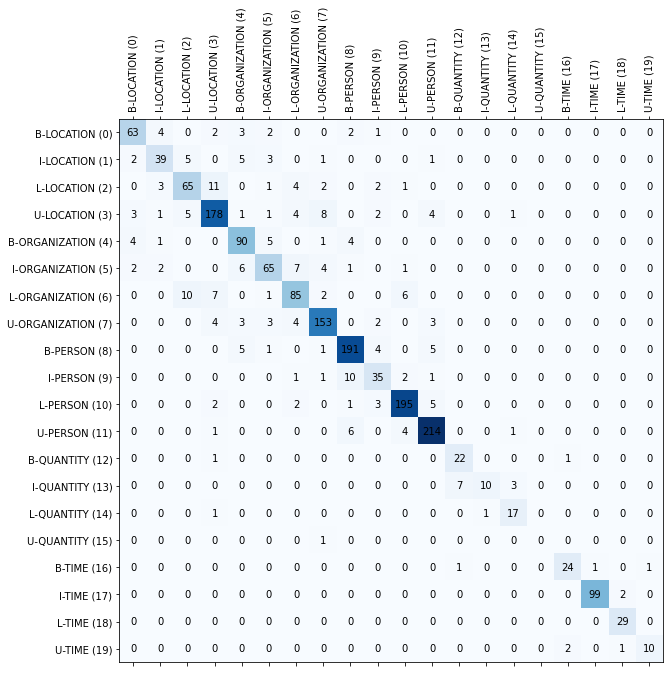



### Model Configuration ###
output_dim: 300, embedding_type: w2v, params: {'optimizer': 'Adam', 'lr': 0.001, 'lstm_units': 100, 'dropout': 0.5, 'batch_size': 64, 'epochs': 200}
Load pretrained embedding from ../checkpoint/embedding/w2v/d300/w2v_wiki_id_case_300

Model Summary
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_7 (Embedding)      (None, 40, 300)           3909300   
_________________________________________________________________
spatial_dropout1d_7 (Spatial (None, 40, 300)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 40, 200)           320800    
_________________________________________________________________
dense_7 (Dense)              (None, 40, 21) 

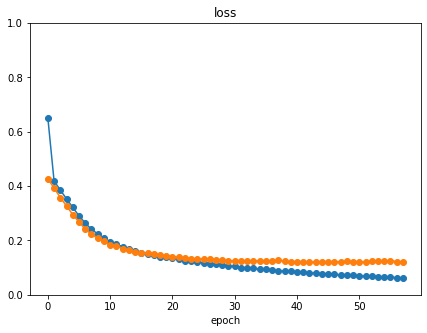

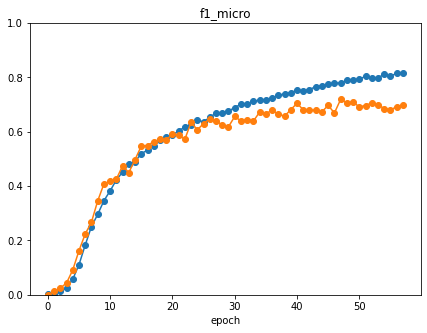

micro averaged f1 score: 0.6770264594708106


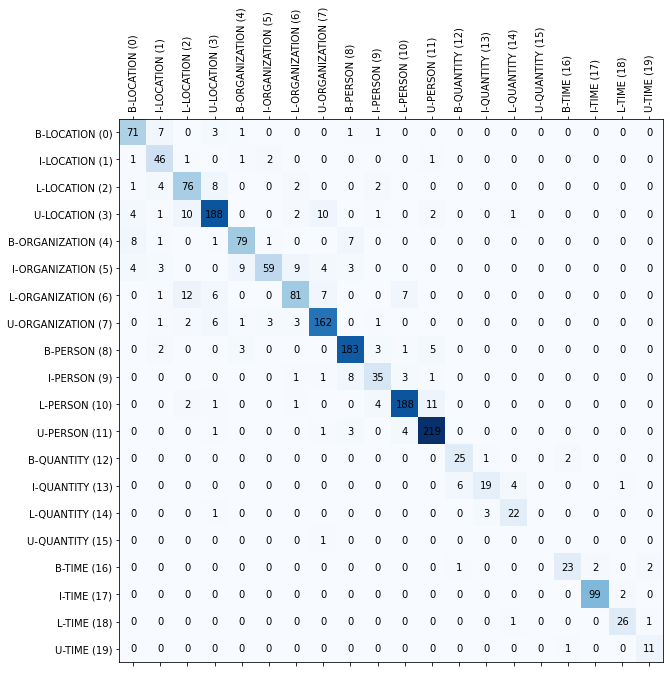



### Model Configuration ###
output_dim: 50, embedding_type: glove, params: {'optimizer': 'Adam', 'lr': 0.001, 'lstm_units': 100, 'dropout': 0.5, 'batch_size': 64, 'epochs': 200}
Load pretrained embedding from ../checkpoint/embedding/glove/d50/glove_wiki_id_case_50


c:\users\mahasiswa\miniconda3\envs\venv\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).



Model Summary
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 40, 50)            651550    
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 40, 50)            0         
_________________________________________________________________
bidirectional_8 (Bidirection (None, 40, 200)           120800    
_________________________________________________________________
dense_8 (Dense)              (None, 40, 21)            4221      
Total params: 776,571
Trainable params: 125,021
Non-trainable params: 651,550
_________________________________________________________________
Epoch 1/200
54/54 [==============================] - 1s 22ms/step - loss: 0.7426 - f1_score_micro:

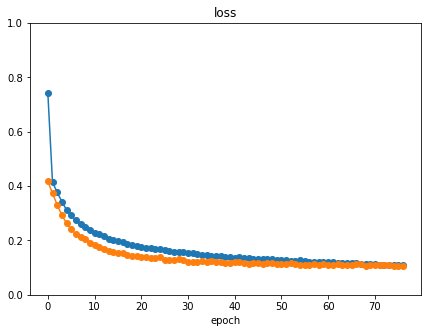

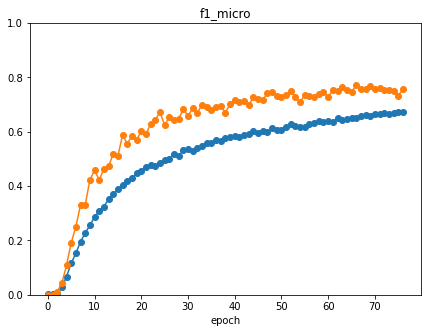

micro averaged f1 score: 0.7274254514909702


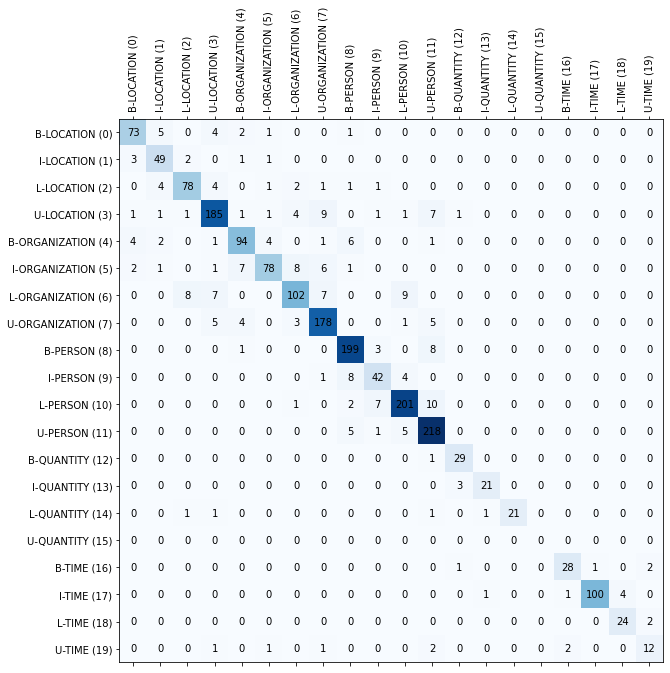



### Model Configuration ###
output_dim: 100, embedding_type: glove, params: {'optimizer': 'Adam', 'lr': 0.001, 'lstm_units': 100, 'dropout': 0.5, 'batch_size': 64, 'epochs': 200}
Load pretrained embedding from ../checkpoint/embedding/glove/d100/glove_wiki_id_case_100

Model Summary
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 40)]              0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 40, 100)           1303100   
_________________________________________________________________
spatial_dropout1d_9 (Spatial (None, 40, 100)           0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 40, 200)           160800    
_________________________________________________________________
dense_9 (Dense)              (None, 40

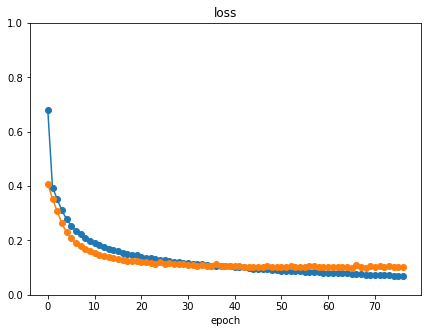

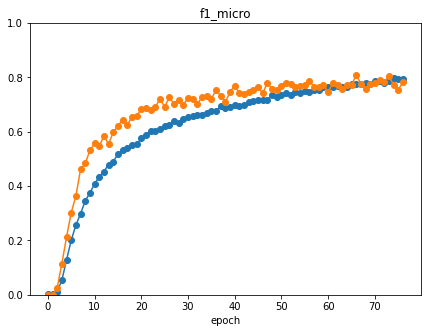

micro averaged f1 score: 0.7543049139017218


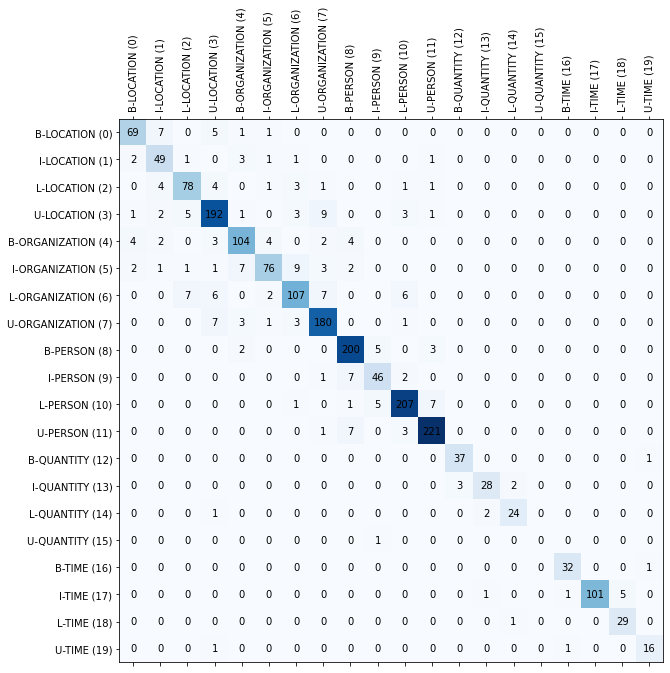



### Model Configuration ###
output_dim: 200, embedding_type: glove, params: {'optimizer': 'Adam', 'lr': 0.001, 'lstm_units': 100, 'dropout': 0.5, 'batch_size': 64, 'epochs': 200}
Load pretrained embedding from ../checkpoint/embedding/glove/d200/glove_wiki_id_case_200

Model Summary
Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 40)]              0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 40, 200)           2606200   
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 40, 200)           0         
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 40, 200)           240800    
_________________________________________________________________
dense_10 (Dense)             (None, 4

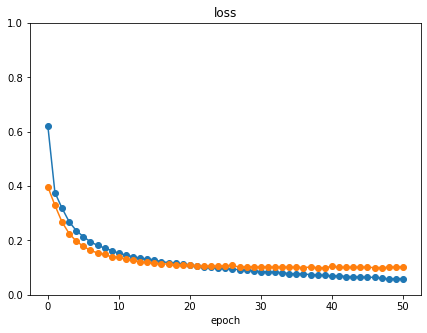

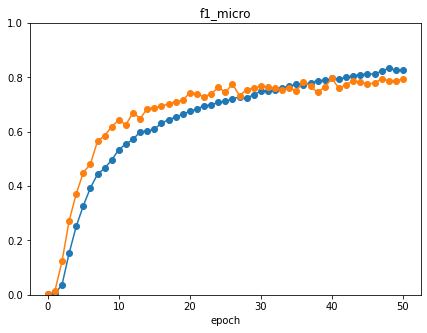

micro averaged f1 score: 0.766904661906762


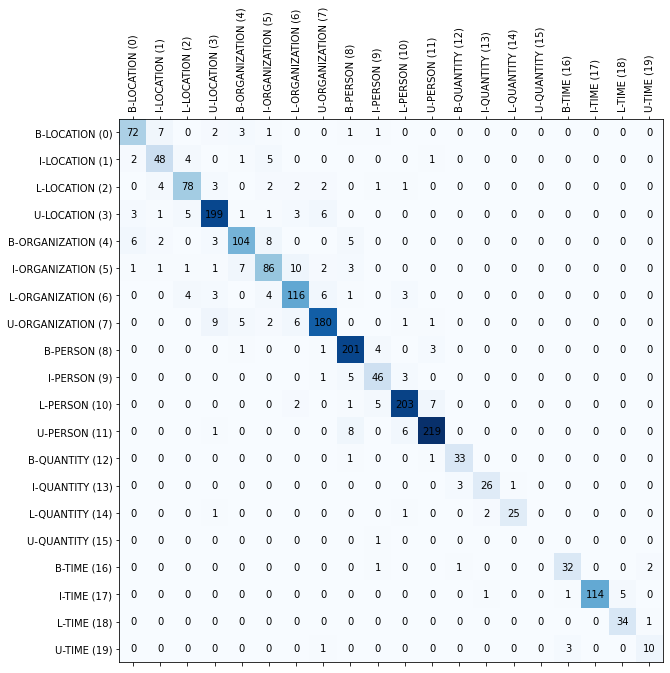



### Model Configuration ###
output_dim: 300, embedding_type: glove, params: {'optimizer': 'Adam', 'lr': 0.001, 'lstm_units': 100, 'dropout': 0.5, 'batch_size': 64, 'epochs': 200}
Load pretrained embedding from ../checkpoint/embedding/glove/d300/glove_wiki_id_case_300

Model Summary
Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 40)]              0         
_________________________________________________________________
embedding_11 (Embedding)     (None, 40, 300)           3909300   
_________________________________________________________________
spatial_dropout1d_11 (Spatia (None, 40, 300)           0         
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 40, 200)           320800    
_________________________________________________________________
dense_11 (Dense)             (None, 4

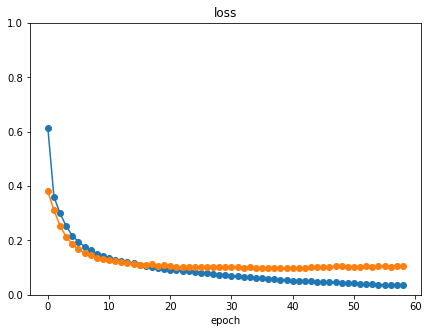

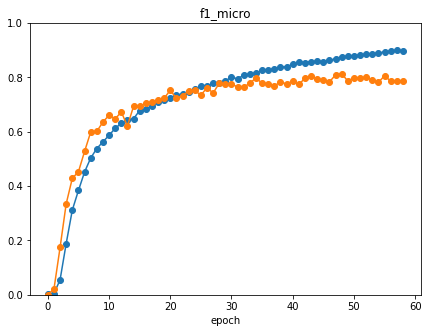

micro averaged f1 score: 0.747165056698866


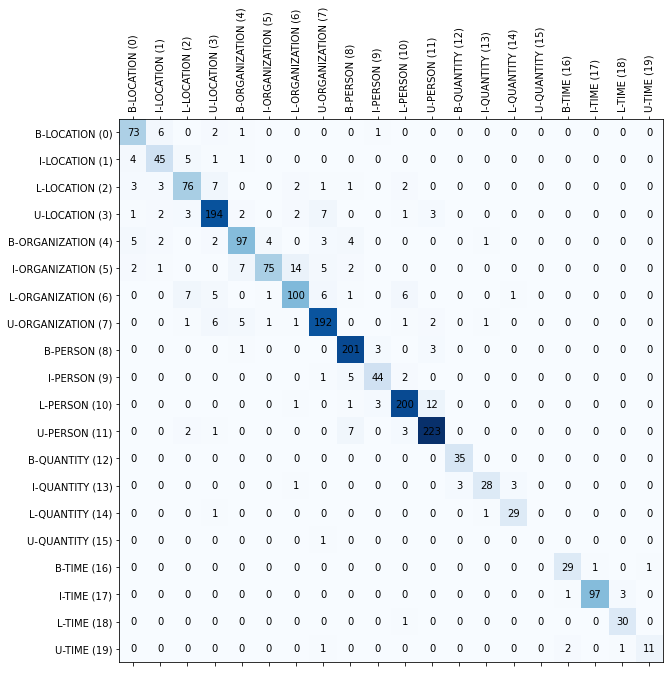



### Model Configuration ###
output_dim: 50, embedding_type: fasttext, params: {'optimizer': 'Adam', 'lr': 0.001, 'lstm_units': 100, 'dropout': 0.5, 'batch_size': 64, 'epochs': 200}
Load pretrained embedding from ../checkpoint/embedding/fasttext/d50/fasttext_wiki_id_case_50

Model Summary
Model: "model_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 40)]              0         
_________________________________________________________________
embedding_12 (Embedding)     (None, 40, 50)            651550    
_________________________________________________________________
spatial_dropout1d_12 (Spatia (None, 40, 50)            0         
_________________________________________________________________
bidirectional_12 (Bidirectio (None, 40, 200)           120800    
_________________________________________________________________
dense_12 (Dense)             (N

Epoch 98/200
54/54 [==============================] - 1s 22ms/step - loss: 0.1281 - f1_score_micro: 0.6102 - val_loss: 0.1160 - val_f1_score_micro: 0.6841
Epoch 99/200
54/54 [==============================] - 1s 22ms/step - loss: 0.1295 - f1_score_micro: 0.6007 - val_loss: 0.1198 - val_f1_score_micro: 0.7011
Epoch 100/200
54/54 [==============================] - 1s 22ms/step - loss: 0.1296 - f1_score_micro: 0.6061 - val_loss: 0.1267 - val_f1_score_micro: 0.7472
Epoch 101/200
54/54 [==============================] - 1s 22ms/step - loss: 0.1251 - f1_score_micro: 0.6176 - val_loss: 0.1165 - val_f1_score_micro: 0.7099
Epoch 102/200
54/54 [==============================] - 1s 22ms/step - loss: 0.1259 - f1_score_micro: 0.6026 - val_loss: 0.1163 - val_f1_score_micro: 0.6676
Epoch 103/200
54/54 [==============================] - 1s 22ms/step - loss: 0.1275 - f1_score_micro: 0.6141 - val_loss: 0.1166 - val_f1_score_micro: 0.7348
Epoch 104/200
54/54 [==============================] - 1s 22ms/ste

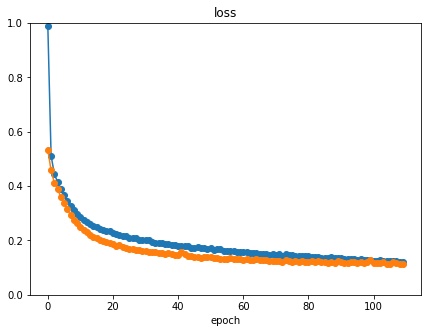

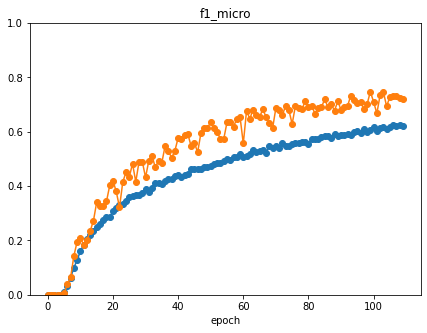

micro averaged f1 score: 0.6774464510709786


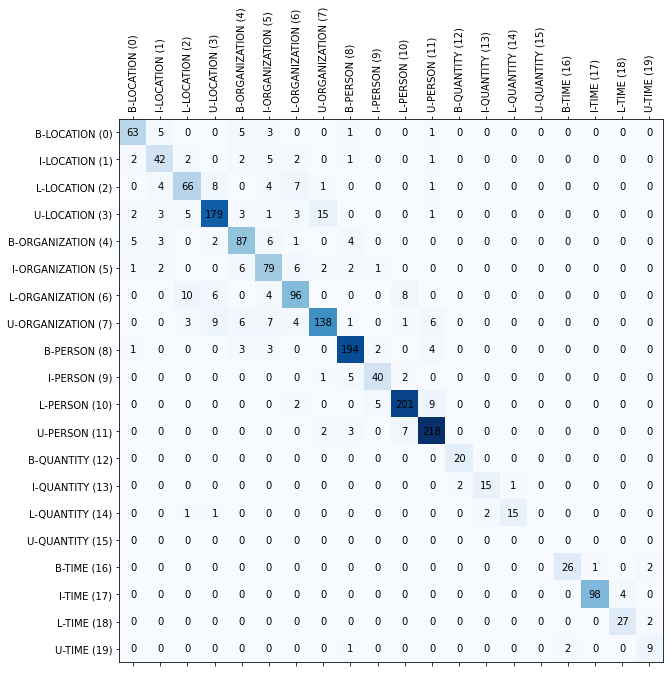



### Model Configuration ###
output_dim: 100, embedding_type: fasttext, params: {'optimizer': 'Adam', 'lr': 0.001, 'lstm_units': 100, 'dropout': 0.5, 'batch_size': 64, 'epochs': 200}
Load pretrained embedding from ../checkpoint/embedding/fasttext/d100/fasttext_wiki_id_case_100

Model Summary
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 40)]              0         
_________________________________________________________________
embedding_13 (Embedding)     (None, 40, 100)           1303100   
_________________________________________________________________
spatial_dropout1d_13 (Spatia (None, 40, 100)           0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 40, 200)           160800    
_________________________________________________________________
dense_13 (Dense)            

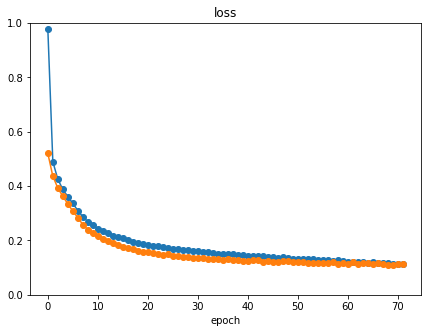

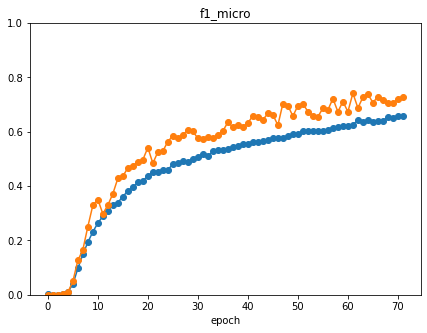

micro averaged f1 score: 0.6913061738765225


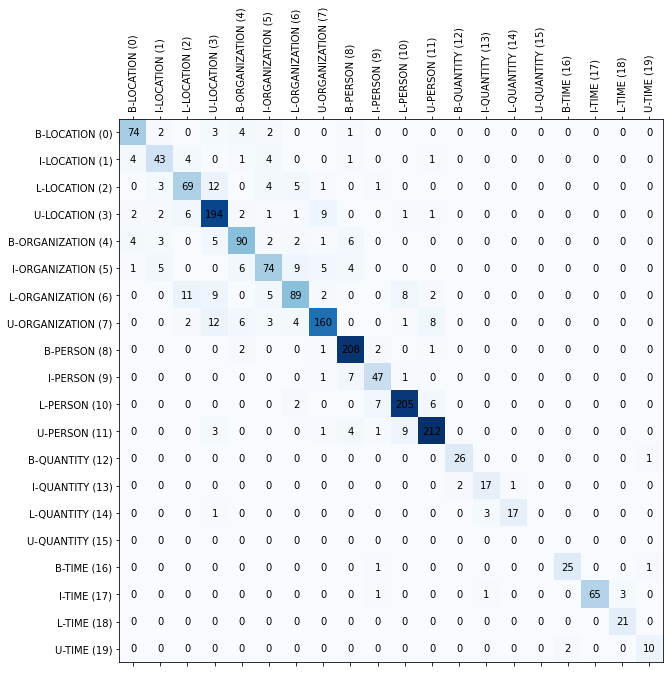



### Model Configuration ###
output_dim: 200, embedding_type: fasttext, params: {'optimizer': 'Adam', 'lr': 0.001, 'lstm_units': 100, 'dropout': 0.5, 'batch_size': 64, 'epochs': 200}
Load pretrained embedding from ../checkpoint/embedding/fasttext/d200/fasttext_wiki_id_case_200

Model Summary
Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 40)]              0         
_________________________________________________________________
embedding_14 (Embedding)     (None, 40, 200)           2606200   
_________________________________________________________________
spatial_dropout1d_14 (Spatia (None, 40, 200)           0         
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 40, 200)           240800    
_________________________________________________________________
dense_14 (Dense)            

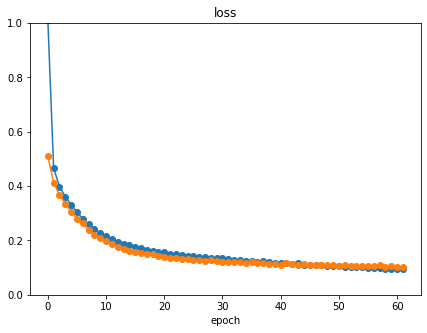

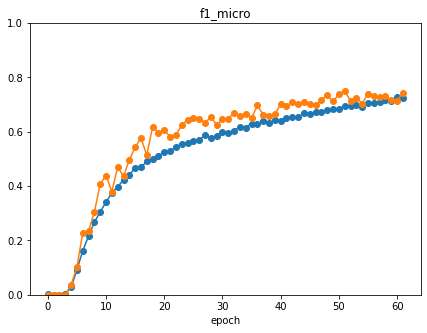

micro averaged f1 score: 0.7093658126837462


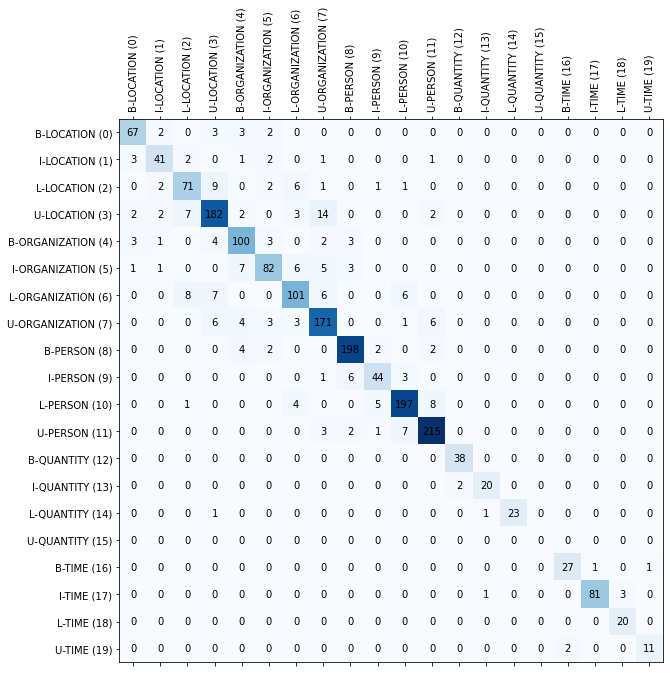



### Model Configuration ###
output_dim: 300, embedding_type: fasttext, params: {'optimizer': 'Adam', 'lr': 0.001, 'lstm_units': 100, 'dropout': 0.5, 'batch_size': 64, 'epochs': 200}
Load pretrained embedding from ../checkpoint/embedding/fasttext/d300/fasttext_wiki_id_case_300

Model Summary
Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 40)]              0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 40, 300)           3909300   
_________________________________________________________________
spatial_dropout1d_15 (Spatia (None, 40, 300)           0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 40, 200)           320800    
_________________________________________________________________
dense_15 (Dense)            

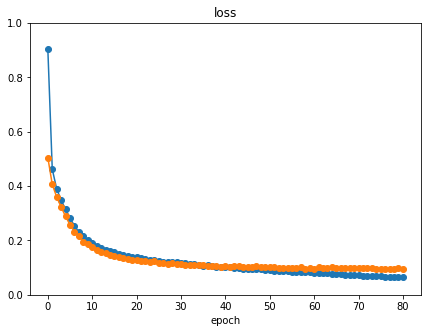

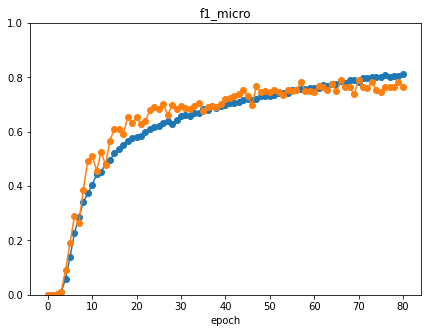

micro averaged f1 score: 0.7282654346913062


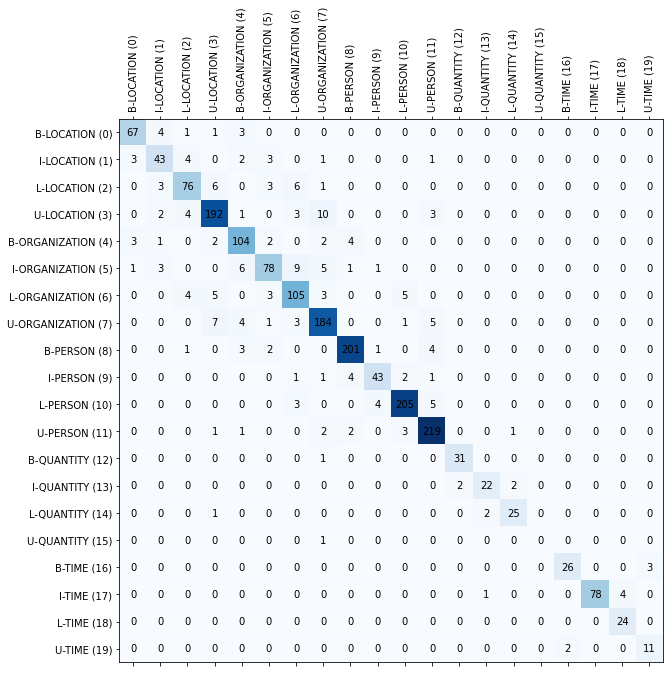

In [19]:
d = {}
for et in embedding_types:
    for od in output_dims:
        score = train_model(params, od, et)
        d.update({f'{et};{od}': score})

In [20]:
d

{'None;50': 0.5993280134397312,
 'None;100': 0.619907601847963,
 'None;200': 0.6518269634607308,
 'None;300': 0.636707265854683,
 'w2v;50': 0.6572868542629148,
 'w2v;100': 0.6522469550608988,
 'w2v;200': 0.6652666946661067,
 'w2v;300': 0.6770264594708106,
 'glove;50': 0.7274254514909702,
 'glove;100': 0.7543049139017218,
 'glove;200': 0.766904661906762,
 'glove;300': 0.747165056698866,
 'fasttext;50': 0.6774464510709786,
 'fasttext;100': 0.6913061738765225,
 'fasttext;200': 0.7093658126837462,
 'fasttext;300': 0.7282654346913062}

(0.0, 1.0)

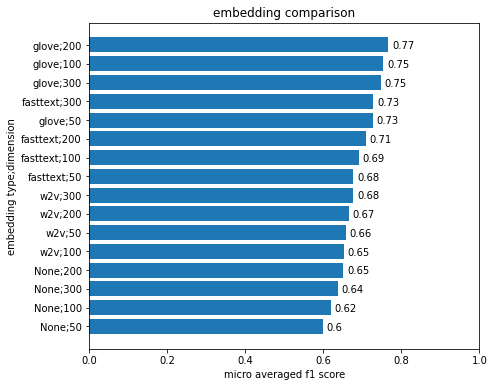

In [56]:
sorted_d = {k: v for k, v in sorted(d.items(), key=lambda item: item[1])}
plt.figure(figsize=(7,6))
plt.barh(list(sorted_d.keys()), sorted_d.values(), align='center')
for i, v in enumerate(sorted_d.values()):
    plt.text(v + .01, i - 0.2, str(round(v, 2)), color='black')
plt.title('embedding comparison')
plt.xlabel('micro averaged f1 score')
plt.ylabel('embedding type;dimension')
plt.xlim(0,1)